In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateKalmanNet import StateKalmanNet

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [13]:
h_true_nonlinear = lambda x: 0.5 * x
f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

Q_true = torch.tensor([[0.1]])
R_true = torch.tensor([[0.1]])

Ex0_true = torch.tensor([[1.0]])
P0_true = torch.tensor([[0.5]])

sys_true = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_true, P0_true)

#  Nepřesná dynamika (lineární aproximace nelineární funkce f)
f_model_nonlinear = lambda x: 0.9 * x 
h_model_nonlinear = h_true_nonlinear
# Nepřesná znalost šumu (podcenění Q)
Q_model = torch.tensor([[0.01]])
R_model = torch.tensor([[0.2]])
# Nepřesný počáteční odhad (pro EKF)
Ex0_model = torch.tensor([[0.5]])
P0_model = torch.tensor([[0.5]])

# Sestavení nepřesného modelu pro filtry
# Funkce h, R jsou pro jednoduchost stejné, ale f, Q, Ex0, P0 jsou jiné
sys_model = Systems.NonlinearSystem(f_model_nonlinear, h_model_nonlinear, Q_model, R_model, Ex0_model, P0_model)
# sys_model = Systems.NonlinearSystem(f_true_nonlinear, h_true_nonlinear, Q_true, R_true, Ex0_model, P0_model)

In [14]:
x_train, y_train = utils.generate_data(sys_true, num_trajectories=3000, seq_len=10)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=200)

full_train_dataset = TensorDataset(x_train, y_train)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [15]:
ekf = Filters.ExtendedKalmanFilter(sys_model)
y_test_seq = y_test.squeeze(0)
ekf_results = ekf.apply_filter(y_test_seq)
x_hat_ekf = ekf_results['x_filtered']
P_hat_ekf = ekf_results['P_filtered']

In [ ]:
state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=10).to(device)
utils.train_state_KalmanNet(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=200, 
    lr=1e-3,
    early_stopping_patience=30
)

Epoch [5/200], Train Loss: 0.245247, Val Loss: 0.227971
Epoch [10/200], Train Loss: 0.208861, Val Loss: 0.200430
Epoch [15/200], Train Loss: 0.187421, Val Loss: 0.182081
Epoch [20/200], Train Loss: 0.164769, Val Loss: 0.160947
Epoch [25/200], Train Loss: 0.151065, Val Loss: 0.148750
Epoch [30/200], Train Loss: 0.148021, Val Loss: 0.145574
Epoch [35/200], Train Loss: 0.147349, Val Loss: 0.145026
Epoch [40/200], Train Loss: 0.146995, Val Loss: 0.144820
Epoch [45/200], Train Loss: 0.147145, Val Loss: 0.144640
Epoch [50/200], Train Loss: 0.146982, Val Loss: 0.144514
Epoch [55/200], Train Loss: 0.147180, Val Loss: 0.144431
Epoch [60/200], Train Loss: 0.146788, Val Loss: 0.144359
Epoch [65/200], Train Loss: 0.146665, Val Loss: 0.144342
Epoch [70/200], Train Loss: 0.146624, Val Loss: 0.144175
Epoch [75/200], Train Loss: 0.146715, Val Loss: 0.144239
Epoch [80/200], Train Loss: 0.146500, Val Loss: 0.144087
Epoch [85/200], Train Loss: 0.146376, Val Loss: 0.144052
Epoch [90/200], Train Loss: 0.14

StateKalmanNet(
  (dnn): DNN_KalmanNet(
    (input_layer): Linear(in_features=2, out_features=20, bias=True)
    (gru): GRU(20, 20)
    (output_layer): Linear(in_features=20, out_features=1, bias=True)
  )
)


Výsledná MSE KalmanNet na nelineárním systému: 0.1545
Výsledná MSE EKF na nelineárním systému:       0.1546


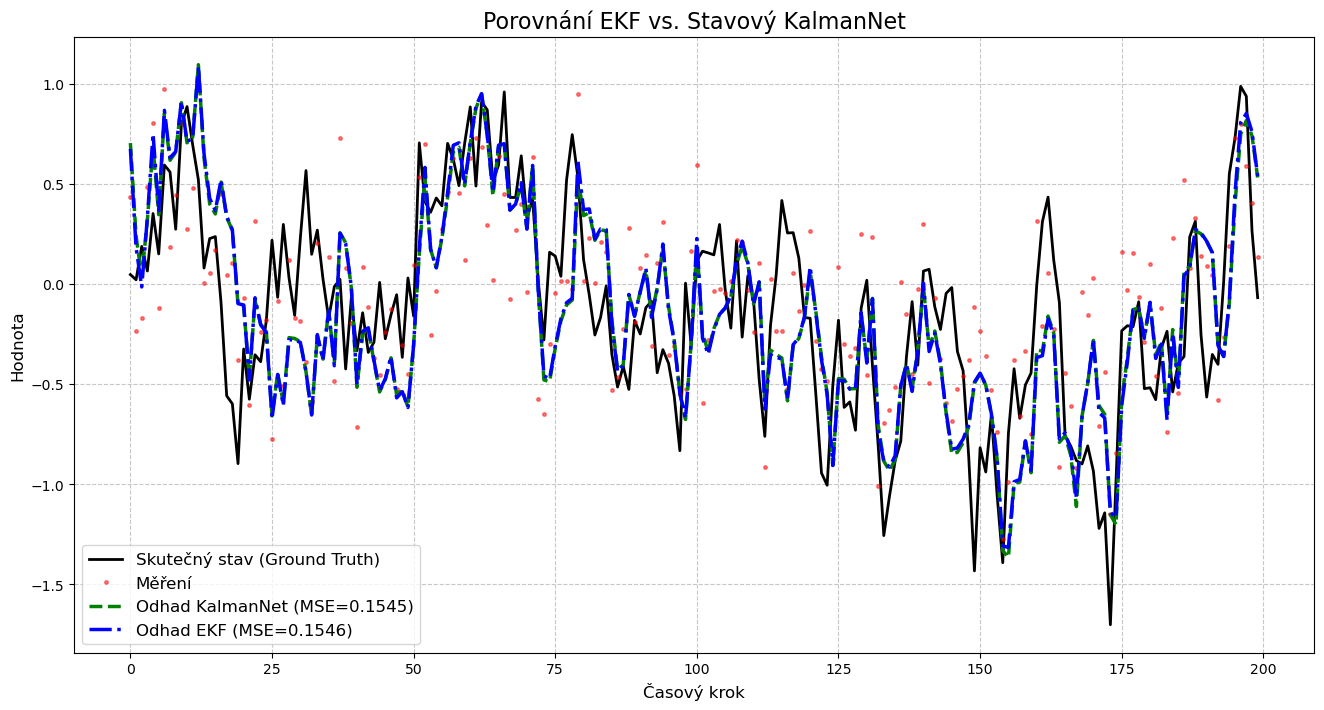

In [12]:
state_knet.eval()

# Získáme testovací sekvenci pozorování
y_test_seq = y_test.squeeze(0).to(device) # Tvar [seq_len, obs_dim]
seq_len_test = y_test_seq.shape[0]

# DŮLEŽITÉ: Resetujeme vnitřní stav filtru před testovacím během
# `batch_size=1`, protože zpracováváme jen jednu trajektorii
state_knet.reset(batch_size=1)

# Seznam pro uložení odhadů z každého kroku
knet_predictions = []

with torch.no_grad():
    # Smyčka přes časovou osu
    for t in range(seq_len_test):
        # Získáme měření pro aktuální časový krok t
        # .unsqueeze(0) přidá batch dimenzi, protože .step() očekává [batch, obs_dim]
        y_t = y_test_seq[t, :].unsqueeze(0)
        
        # Provedeme jeden krok filtrace
        x_filtered_t = state_knet.step(y_t)
        
        # Uložíme výsledek (odstraníme batch dimenzi)
        knet_predictions.append(x_filtered_t.squeeze(0))

# Spojíme odhady do jednoho tenzoru
# Tvar: [seq_len, state_dim]
x_hat_knet = torch.stack(knet_predictions, dim=0).cpu()

# --- 2. Příprava dat a výpočet metrik ---

x_true_seq = x_test.squeeze(0).cpu()
x_hat_ekf_seq = x_hat_ekf.cpu() # Předpokládáme, že toto je již sekvence

# Přesuneme y_test na CPU pro vykreslení
y_meas_seq = y_test.squeeze(0).cpu()

mse_criterion = nn.MSELoss()
# Porovnáváme tenzory stejného tvaru: [seq_len, state_dim]
mse_knet = mse_criterion(x_hat_knet, x_true_seq)
mse_ekf = mse_criterion(x_hat_ekf_seq, x_true_seq)

print(f"\nVýsledná MSE KalmanNet na nelineárním systému: {mse_knet.item():.4f}")
print(f"Výsledná MSE EKF na nelineárním systému:       {mse_ekf.item():.4f}")

# --- 3. Grafické porovnání ---

plt.figure(figsize=(16, 8))
plt.title("Porovnání EKF vs. Stavový KalmanNet", fontsize=16)

# Převod na numpy pro plotování
x_true_plot = x_true_seq.numpy()
y_meas_plot = y_meas_seq.numpy()
x_hat_knet_plot = x_hat_knet.numpy()
x_hat_ekf_plot = x_hat_ekf_seq.numpy()

plt.plot(x_true_plot, 'k-', linewidth=2, label="Skutečný stav (Ground Truth)")
plt.plot(y_meas_plot, 'r.', markersize=5, alpha=0.5, label="Měření")
plt.plot(x_hat_knet_plot, 'g--', linewidth=2.5, label=f"Odhad KalmanNet (MSE={mse_knet.item():.4f})")
plt.plot(x_hat_ekf_plot, 'b-.', linewidth=2.5, label=f"Odhad EKF (MSE={mse_ekf.item():.4f})")

plt.xlabel("Časový krok", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()